In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time

In [226]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [227]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039


In [228]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [229]:
split = 0.67
train_size = int(len(data)*split)
test_size = len(data)-train_size
train = data[0:train_size,:]
test = data[train_size:len(data),:]
print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [230]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
# print(trainY[:5])

(839, 3, 2)


In [231]:
# trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

In [232]:
units = 100
drop = 0.2
epoch = 20

model = Sequential()
model.add(LSTM(units, input_shape=(look_back, 2)))
# model.add(Dropout(drop))
model.add(Dense(2))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='nadam')
model.summary()
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
839/839 [==============================] - 6s 7ms/step - loss: 0.0012
Epoch 2/20
839/839 [==============================] - 5s 6ms/step - loss: 3.7186e-04
Epoch 3/20
839/839 [==============================] - 6s 7ms/step - loss: 3.0543e-04
Epoch 4/20
839/839 [==============================] - 6s 7ms/step - loss: 2.6439e-04
Epoch 5/20
839/839 [==============================] - 5s 6ms/step - loss: 2.2852e-04
Epoch 6/20
839/839 [==============================] - 5s 6ms/step - loss: 1.9375e-04
Epoch 7/20
839/839 [========

In [233]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [234]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [235]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 8.64 RMSE
Test Score: 17.13 RMSE


In [236]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict


In [237]:
# print(data.shape)
# print(train.shape)
# print(test.shape)
# print(trainPredict.shape)
# print(testPredict.shape)

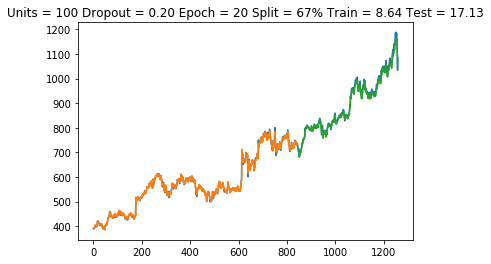

In [238]:
col = 0
plt.plot(scaler.inverse_transform(data)[:,col])
plt.plot(trainPredictPlot[:,col])
plt.plot(testPredictPlot[:,col])
plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
		(units, drop, epoch, split*100, trainScore, testScore))
plt.show()